In [1]:
import sys, os, importlib, numpy as np, pandas as pd
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.metrics import precision_recall_curve, auc as auc_fn

from src import data as data_mod, features as features_mod, utils as utils_mod
importlib.reload(data_mod); importlib.reload(features_mod); importlib.reload(utils_mod)
from src.data import get_data
from src.features import add_features
from src.utils import make_labels

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["axes.grid"] = True


In [2]:
TICKER = "AAPL"                 # change as needed
START, END = "2015-01-01", "2023-12-31"
TAU, DEAD_ZONE = 0.001, True    # ±0.1% dead-zone

df = get_data(TICKER, start=START, end=END)
df = add_features(df)
df = make_labels(df, tau=TAU, dead_zone=DEAD_ZONE)

feat_cols = [c for c in df.columns if c not in ["date","open","high","low","close","volume","ret_next","y"]]
X = df[feat_cols].values
y = df["y"].astype(int).values

n = len(df)
i_tr, i_va, i_te = int(0.70*n), int(0.85*n), n
X_tr, y_tr = X[:i_tr], y[:i_tr]
X_va, y_va = X[i_tr:i_va], y[i_tr:i_va]
X_te, y_te = X[i_va:], y[i_va:]

scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr); X_va = scaler.transform(X_va); X_te = scaler.transform(X_te)

len(df), len(feat_cols)


(2078, 8)

In [3]:
# Logistic Regression
lr = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None)
lr.fit(X_tr, y_tr)
p_va_lr = lr.predict_proba(X_va)[:,1]
p_te_lr = lr.predict_proba(X_te)[:,1]

# XGBoost (if available)
if HAS_XGB:
    xgb = XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=42, n_jobs=-1
    )
    xgb.fit(X_tr, y_tr)
    p_va_xgb = xgb.predict_proba(X_va)[:,1]
    p_te_xgb = xgb.predict_proba(X_te)[:,1]
else:
    p_va_xgb = p_te_xgb = None

print("AUC (VAL) — LR:", roc_auc_score(y_va, p_va_lr))
print("AUC (TEST) — LR:", roc_auc_score(y_te, p_te_lr))
if HAS_XGB:
    print("AUC (VAL) — XGB:", roc_auc_score(y_va, p_va_xgb))
    print("AUC (TEST) — XGB:", roc_auc_score(y_te, p_te_xgb))


AUC (VAL) — LR: 0.48589780541030186
AUC (TEST) — LR: 0.474127606855255
AUC (VAL) — XGB: 0.5453534812862849
AUC (TEST) — XGB: 0.4545942597563494


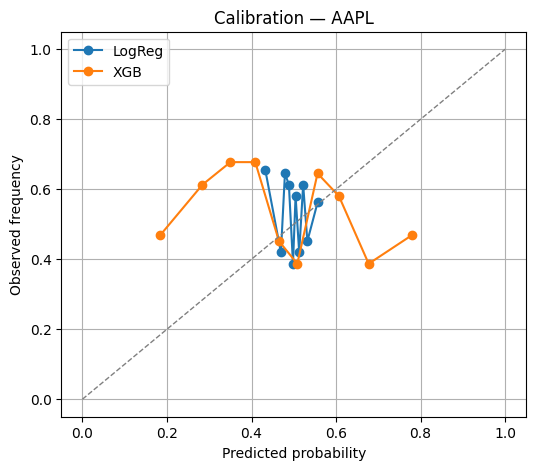

Brier (LR):  0.253512
Brier (XGB): 0.295353


In [4]:
def plot_calibration(y_true, p_pred, label, n_bins=10):
    frac_pos, mean_pred = calibration_curve(y_true, p_pred, n_bins=n_bins, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o", label=label)

plt.figure(figsize=(6,5))
plot_calibration(y_te, p_te_lr, "LogReg")
if HAS_XGB: plot_calibration(y_te, p_te_xgb, "XGB")
plt.plot([0,1],[0,1],"--", color="gray", lw=1)
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title(f"Calibration — {TICKER}")
plt.legend(); plt.show()

print("Brier (LR): ", round(brier_score_loss(y_te, p_te_lr), 6))
if HAS_XGB:
    print("Brier (XGB):", round(brier_score_loss(y_te, p_te_xgb), 6))


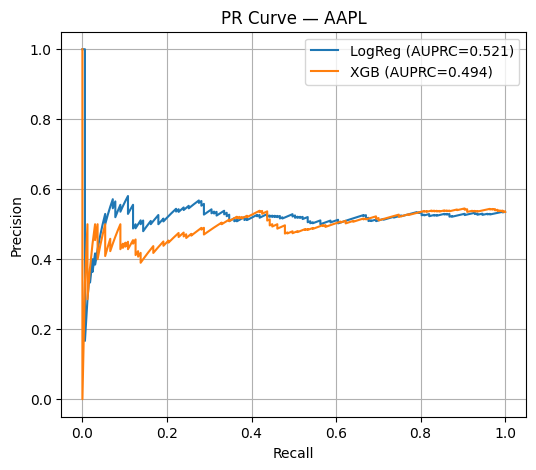

In [5]:
def plot_pr(y_true, p_pred, label):
    pr, rc, _ = precision_recall_curve(y_true, p_pred)
    plt.plot(rc, pr, label=f"{label} (AUPRC={auc_fn(rc, pr):.3f})")

plt.figure(figsize=(6,5))
plot_pr(y_te, p_te_lr, "LogReg")
if HAS_XGB: plot_pr(y_te, p_te_xgb, "XGB")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve — {TICKER}")
plt.legend(); plt.show()


In [6]:
from sklearn.inspection import permutation_importance

if HAS_XGB:
    # XGBoost built-in importance (gain)
    xgb_gain = pd.DataFrame({
        "feature": feat_cols,
        "gain_importance": xgb.get_booster().get_score(importance_type="gain")
    }).fillna(0).sort_values("gain_importance", ascending=False)
    display(xgb_gain.head(20))

    # Permutation importance on TEST
    perm = permutation_importance(xgb, X_te, y_te, n_repeats=10, random_state=42, scoring="roc_auc")
    perm_df = pd.DataFrame({
        "feature": feat_cols,
        "perm_importance": perm.importances_mean
    }).sort_values("perm_importance", ascending=False)
    display(perm_df.head(20))

    # Plot top-20 permutation importance
    top = perm_df.head(20).iloc[::-1]
    plt.figure(figsize=(8,6))
    plt.barh(top["feature"], top["perm_importance"])
    plt.title(f"Permutation importance (AUC drop) — {TICKER}")
    plt.tight_layout(); plt.show()

    # Save artifacts
    from pathlib import Path
    Path("../data").mkdir(parents=True, exist_ok=True)
    xgb_gain.head(20).to_csv("../data/xgb_gain_importance_top20.csv", index=False)
    perm_df.head(20).to_csv("../data/permutation_importance_top20.csv", index=False)
else:
    print("XGBoost not available; skip importance.")


ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [ ]:
if HAS_XGB:
    # pick a few confident predictions
    idx_sorted = np.argsort(-np.abs(p_te_xgb - 0.5))
    for i in idx_sorted[:3]:
        print(f"Example idx {i} | prob={p_te_xgb[i]:.3f} | true={y_te[i]}")
        shap.force_plot(
            base_value=explainer.expected_value,
            shap_values=shap_values[i],
            features=X_te[i],
            feature_names=feat_cols,
            matplotlib=True,
            show=True
        )


In [ ]:
rows = []
rows.append({
    "model": "logreg",
    "AUC_test": roc_auc_score(y_te, p_te_lr),
    "Brier_test": brier_score_loss(y_te, p_te_lr)
})
if HAS_XGB:
    rows.append({
        "model": "xgb",
        "AUC_test": roc_auc_score(y_te, p_te_xgb),
        "Brier_test": brier_score_loss(y_te, p_te_xgb)
    })
summary = pd.DataFrame(rows).round(4)
display(summary)

from pathlib import Path
Path("../data").mkdir(parents=True, exist_ok=True)
summary.to_csv("../data/explainability_summary.csv", index=False)
if HAS_XGB:
    # save top-20 global shap importances
    imp.head(20).to_csv("../data/shap_importance_top20.csv", index=False)
"Saved explainability artifacts to data/."
